In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from skimage.feature import hog
from skimage import exposure
from skimage.transform import rotate
import pickle
from tqdm import tqdm
import timeit
from joblib import Parallel, delayed
import os
%matplotlib inline

## Utils

### Read csv file function

In [2]:
def read_file(filename, hist=False):
    """
      Read csv file.
      if hist=True, images will be load in Image Histogram, a vector has 256 elements
    """
    df = pd.read_csv(filename)
    if hist:
        pixels = np.empty((df.shape[0], 256))
        for i in range(df.shape[0]):
            tmp = df.iloc[i].value_counts(sort=False).reindex(range(0, 256), fill_value=0).to_numpy()
            pixels[i] = tmp
    else:
        pixels = df.drop(columns=['label']).values

    labels = df.label.values
    pixels = pixels.astype(np.float64)
    return pixels, labels

### Load and save function

In [3]:
def save_pickle(data, filename):
    '''
        Write data to pickle file
    '''
    pickle.dump(data, open(filename, 'wb'))

def load_pickle(filename):
    """
        Load data from pickle file
    """
    return pickle.load(open(filename, 'rb'))

### Visualization function

In [4]:
def show_image_by_range(pixels, labels, start=0, end=1, img_size=28):
    """
        Show images in range from start to end.
    """
    pixels_tmp = pixels.reshape(-1, img_size, img_size, 1)
    plt.figure(figsize=(12, 12))

    for i in range(start, end):
        plt.subplot((end - start) // 4 + 1, 4, i + 1)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(pixels_tmp[i, :, :, 0], cmap='gray')

    plt.show()

def show_image_by_condition(pixels, labels, label_condition=None, numbers=24, img_size=28):
    """
        Show images by label
    """
    pixels_tmp = pixels.reshape(-1, img_size, img_size, 1)
    plt.figure(figsize=(12, 12))

    cnt = 0
    if label_condition is None:
        label_condition_set = set(np.unique(y_train))
    else:
        label_condition_set = set(label_condition)

    n_images = len(pixels)
    n_condition = len(label_condition_set)
    cached_label = set()
    while cnt < numbers:
        idx = np.random.randint(0, n_images)
        if labels[idx] in label_condition_set and (labels[idx] not in cached_label or cnt >= n_condition):
            cnt += 1
            cached_label.add(labels[idx])
            plt.subplot(numbers // 4 + 1, 4, cnt)
            plt.axis('off')
            plt.title(labels[idx])
            plt.imshow(pixels_tmp[idx, :, :, 0], cmap='gray')

    plt.show()

## Read and show data

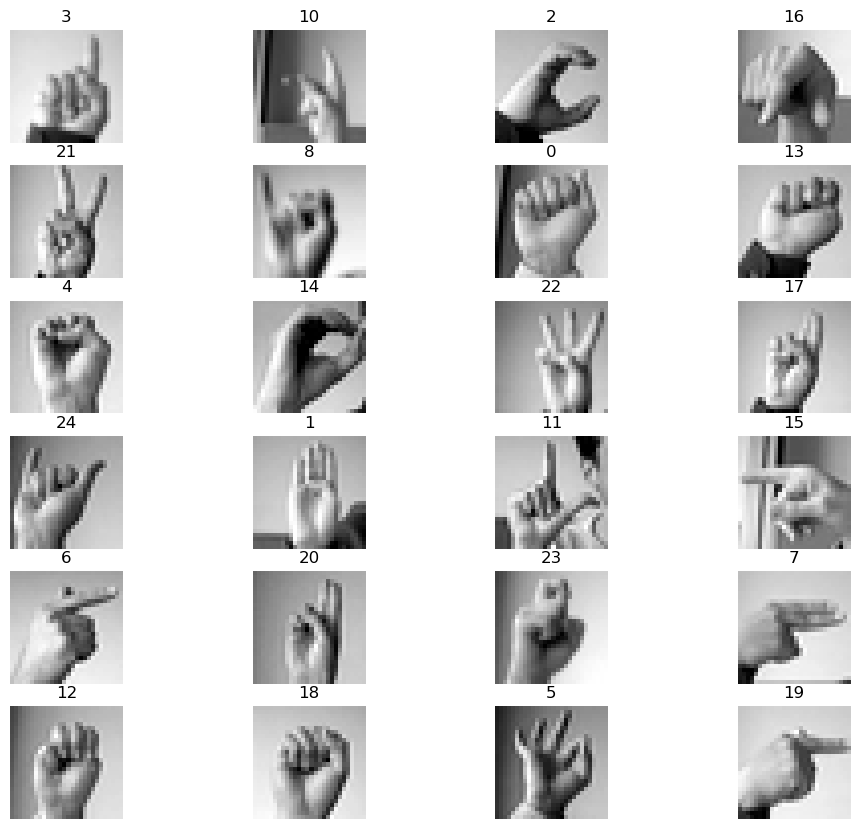

In [5]:
# read data from csv file
X_train, y_train = read_file('sign_mnist_train/sign_mnist_train.csv')
X_test, y_test = read_file('sign_mnist_test/sign_mnist_test.csv')

# normalize data from 0 to 1 range 
X_train /= 255
X_test /= 255

# Visualize images
show_image_by_condition(X_train, y_train, numbers=24)

### Baseline

I build a baseline model with default hyperparameters

In [6]:
# Train baseline model
start = timeit.default_timer()

model = LogisticRegression(max_iter=10000, solver='item', multi_class='auto')
scores = cross_val_score(model, X_train, y_train, cv=5)

end = timeit.default_timer()
print("Fit time:", end - start)
print("Accuracy: %.2f" % (scores.mean() * 100))

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/tiago/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/tiago/.local/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/tiago/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/tiago/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'solver' parameter of LogisticRegression must be a str among {'saga', 'newton-cholesky', 'newton-cg', 'sag', 'liblinear', 'lbfgs'}. Got 'item' instead.


### Feature Extraction: Experiment with Image Histogram

In [ ]:
# Read image histogram
X_train_hist, y_train_hist = read_file('../input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv', hist=True)

In [7]:
# Train model with histogram features
start = timeit.default_timer()

histogram_model = LogisticRegression(max_iter=10000, solver='lbfgs', multi_class='auto')
scores = cross_val_score(histogram_model, X_train_hist, y_train_hist, cv=5)

end = timeit.default_timer()
print("Fit time:", end - start)
print("Accuracy: %.2f" % (scores.mean() * 100))

NameError: name 'X_train_hist' is not defined

### Feature Extraction: Experiment with Histogram of Oriented Gradient

In [8]:
def extract_hog(img, img_size=28, orientations=9, pixels_per_cell=(2, 2), cells_per_block=(1, 1)):
    """
        Histogram of Oriented Gradients
    """
    fd = hog(img.reshape((img_size, img_size)), orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=False)

    return fd

def call_parallel_extraction(images):
    """
        Process images parallelly
    """
    features = Parallel(n_jobs=os.cpu_count())(delayed(extract_hog)(img) for img in tqdm(images))
    return np.array(features)

Show feature images to choose size of cell and size of block

ValueError: The input image is too small given the values of pixels_per_cell and cells_per_block. It should have at least: 32 rows and 32 cols.

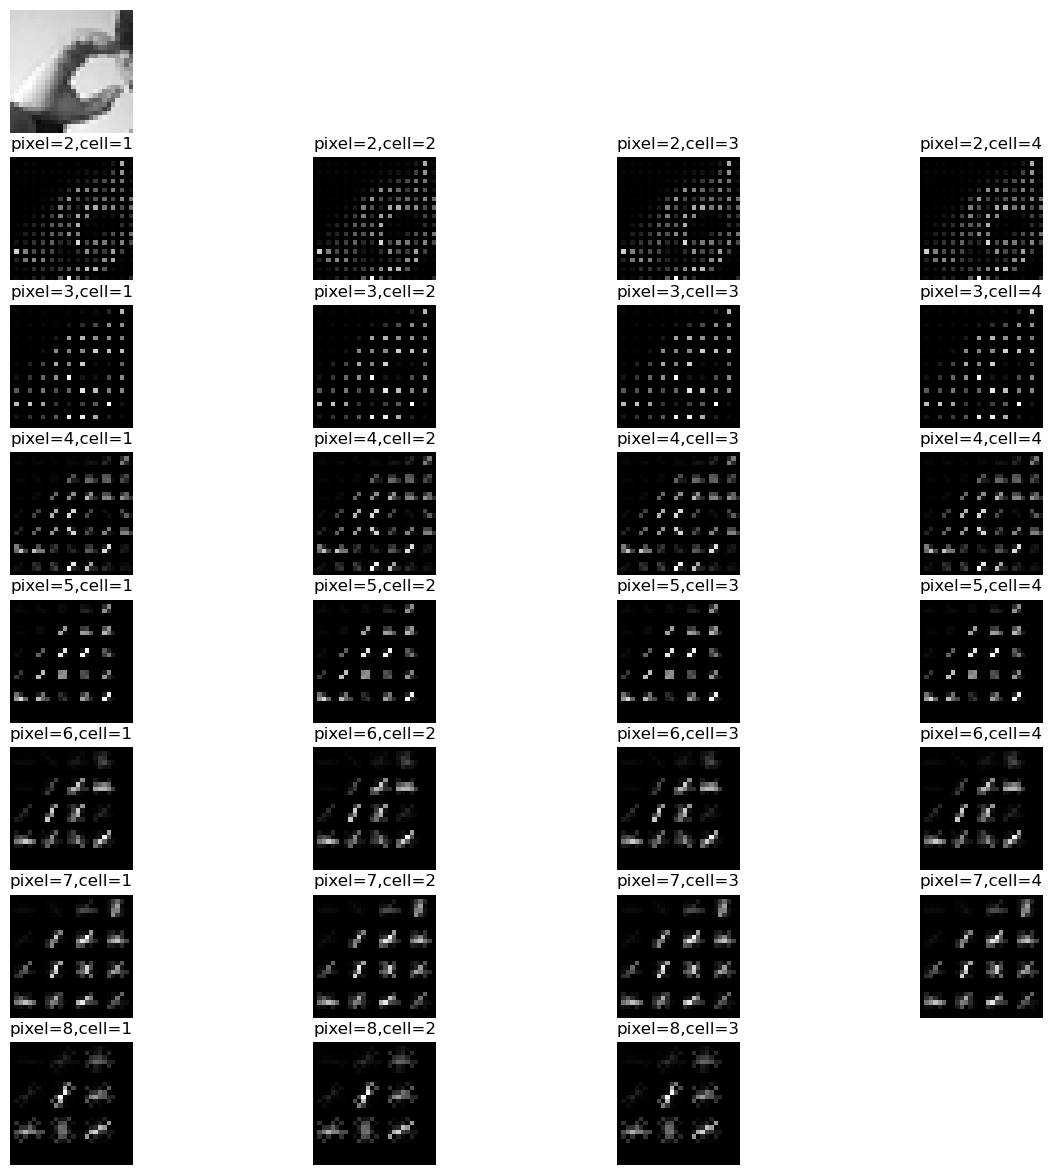

In [9]:
# Show hog features
represent_index = 3
plt.figure(figsize=(15, 15))
plt.subplot(8, 4, 1)
plt.imshow(X_train[represent_index].reshape(28, 28), cmap='gray')
plt.axis('off')
cnt = 2
for n_pixel in range(2, 9):
    for n_cell in range(1, 5):
        _, represent_hog = hog(X_train[represent_index: 4].reshape((28, 28)), \
                               orientations=9, pixels_per_cell=(n_pixel, n_pixel), \
                               cells_per_block=(n_cell, n_cell), visualize=True)
        plt.subplot(8, 4, cnt + 3)
        cnt += 1
        plt.title('pixel=' + str(n_pixel) + ',cell=' + str(n_cell))
        plt.imshow(represent_hog, cmap='gray')
        plt.axis('off')
plt.show()

In [ ]:
# Features extraction using HOG
X_train_hog = call_parallel_extraction(X_train)
X_test_hog = call_parallel_extraction(X_test)

In [ ]:
# Train model again
start = timeit.default_timer()

model = LogisticRegression(max_iter=10000, solver='lbfgs', multi_class='auto')
model.fit(X_train_hog, y_train)

end = timeit.default_timer()
print("Fit time:", end - start)

y_pred = model.predict(X_test_hog)
print("Accuracy: %.2f" % (accuracy_score(y_test, y_pred) * 100))

Visualize confusion matrix to see which labels have many misclassified

Text(0.5, 145.31999999999996, 'Predicted label')

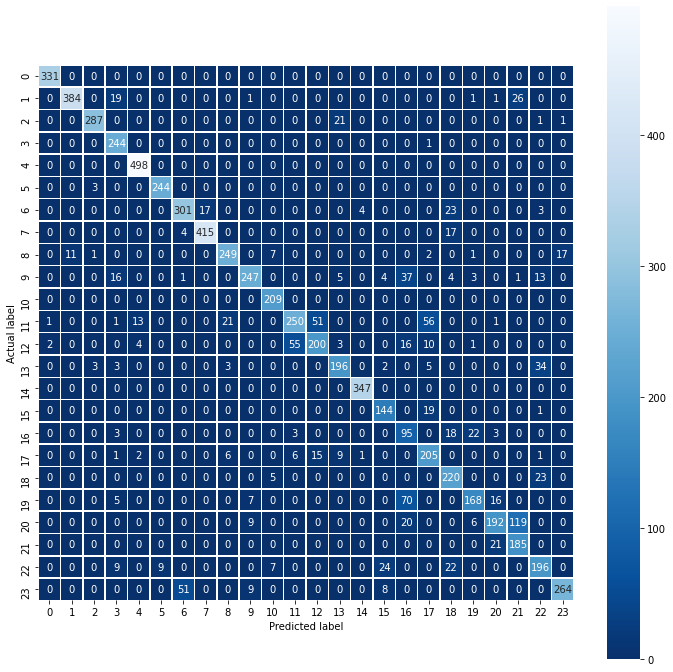

In [13]:
# Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred = y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, 
            linewidths=.5, square = True, cmap = 'Blues_r', fmt='0.4g');

plt.ylabel('Actual label')
plt.xlabel('Predicted label')

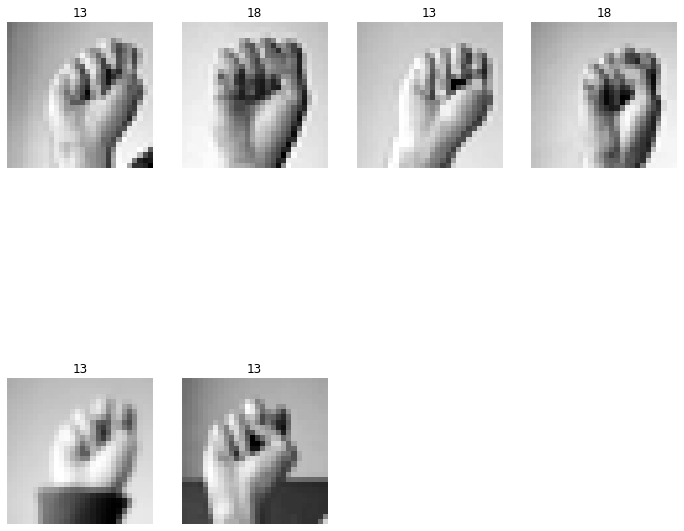

In [14]:
show_image_by_condition(X_test, y_test, label_condition=[13, 18], numbers=6)

### Find good model hyperparameters

In [ ]:
# Set up hyperparameters
params = []
for n_component in np.arange(300, 1000, 50):
    for C_value in np.logspace(-3, 3, 7):
        params.append({
        "pca__n_components" : n_component,
        "clf__estimator__C" : C_value 
        })

best_score = 0
best_param = None

# Loop through hyperparameters and choose the best fit
full_thing = []
for param in params:
    pipeline = Pipeline([
                      ('pca', PCA()),
                      ('clf', OneVsOneClassifier(
                          LogisticRegression(max_iter=10000, solver='lbfgs', multi_class='auto'))
                      )
    ])

    pipeline.set_params(**param)
    start = timeit.default_timer()
    pipeline.fit(X_train_hog, y_train)
    stop = timeit.default_timer()
    print("=============")
    print("Param", param)
    print("Training time: %.2f" % (stop - start))
    curr_score = pipeline.score(X_test_hog, y_test)
    print("Accuracy: %.2f" % (curr_score * 100))
    
    full_thing.append({"param": param,
                      "accuracy": (curr_score * 100),
                      "trainig time": (stop-start)}
                      )
    if curr_score > best_score:
        best_param = param
        best_score = curr_score

print("Best param:", best_param)

Param {'pca__n_components': 300, 'clf__estimator__C': 0.001}
Training time: 11.54
Accuracy: 75.18
Param {'pca__n_components': 300, 'clf__estimator__C': 0.01}
Training time: 12.56
Accuracy: 84.38
Param {'pca__n_components': 300, 'clf__estimator__C': 0.1}
Training time: 14.34
Accuracy: 86.24
Param {'pca__n_components': 300, 'clf__estimator__C': 1.0}
Training time: 14.88
Accuracy: 87.05
Param {'pca__n_components': 300, 'clf__estimator__C': 10.0}
Training time: 15.87
Accuracy: 87.99
Param {'pca__n_components': 300, 'clf__estimator__C': 100.0}
Training time: 15.31
Accuracy: 87.35
Param {'pca__n_components': 300, 'clf__estimator__C': 1000.0}
Training time: 15.23
Accuracy: 87.91
Param {'pca__n_components': 350, 'clf__estimator__C': 0.001}
Training time: 12.31
Accuracy: 75.40
Param {'pca__n_components': 350, 'clf__estimator__C': 0.01}
Training time: 14.23
Accuracy: 84.36
Param {'pca__n_components': 350, 'clf__estimator__C': 0.1}
Training time: 14.88
Accuracy: 86.53
Param {'pca__n_components': 

After ran this code, I decided to choose C=1000 and PCA_n_components=950

## Final

In [ ]:
 CONFIGS = {
    'C' : 1000,
    'MAX_ITER' : 10000,
    'N_COMPONENTS' : 950,
}

def train(X_train, y_train, model=None):
    """
        Build and train model.
    """

    X_train = call_parallel_extraction(X_train)

    print("=====TRAINING=====")
    if model is None:
        print("Step 0: Initializing model...")
        model = Pipeline([
                            ('pca', PCA(n_components=CONFIGS['N_COMPONENTS'])),
                            ('clf', OneVsOneClassifier(
                                LogisticRegression(C=CONFIGS['C'], 
                                                   max_iter=CONFIGS['MAX_ITER'], 
                                                   solver='lbfgs', multi_class='auto')))
        ])

    print("Step 1: Start training model...")
    model.fit(X_train, y_train)

    print("Finished training model!")
    return model

def predict(X_test, y_test, model=None):
    """
        Evaluation function.
    """

    X_test = call_parallel_extraction(X_test)

    print("=====PREDICTION=====")
    if model is None: 
        print("Step 0: Start loading model...")
        model = load_pickle(CONFIGS['MODEL_PATH'])

    print("Step 1: Predicting...")
    y_pred = model.predict(X_test)

    print("Step 2: Scoring model...")
    missed_labels = np.sum(y_pred != y_test)
    accuracy = accuracy_score(y_test, y_pred)

    print("Accuracy: {:.5f}".format(accuracy))
    print("Missed Label: ", missed_labels)

    print("Finished predicting model!")
    return accuracy, missed_labels


## Training and Evaluate

In [ ]:
# read data from csv file
X_train, y_train = read_file('../input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv')
X_test, y_test = read_file('../input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv')

# normalize data from 0 to 1 range 
X_train /= 255
X_test /= 255

# train
model = train(X_train, y_train)

# get test score
_ = predict(X_test, y_test, model)